# **Dyna-Q**


In [137]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [138]:
n_steps = 0


In [139]:
class Env():
    def __init__(self) -> None:
        self.coordinates = {
            'A': ((6, 1),),
            'W': ((3, range(3)), (range(5, 8), 3)),
            'T': ((range(3), 8), (3, range(8, 12))),
            'P': ((6, 10), (0, 11)),
            'LP': ((1, 2),),
            'G': ((1, 10),)
        }
        self.generate_grid()
        self.generate_reward_map()

    def generate_grid(self):
        grid = np.zeros((8, 12), dtype=np.object0)
        for key in list(self.coordinates.keys()):
            for values in self.coordinates[key]:
                grid[values] = key
        self.grid = pd.DataFrame(grid)

    def generate_reward_map(self):
        reward_map = np.zeros((8, 12), dtype=np.float32)
        reward_map[self.coordinates['G'][0]] = 1
        self.reward_map = pd.DataFrame(reward_map)

    def get_reward(self, coordinates: tuple = None, reverse:bool=True):
        """
        Takes a coordinate from the agent and returns the associated reward
        for transitioning to that state
        The coordinates are reversed before querying the dataframe as 
        agent(state) = (x,y) = pd.Dataframe.loc(y,x)
        """
        if reverse: return self.reward_map.loc[coordinates[::-1]]
        else: return self.reward_map.loc[coordinates]


In [140]:
env = Env()

In [141]:
env.grid

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,T,0,0,P
1,0,0,LP,0,0,0,0,0,T,0,G,0
2,0,0,0,0,0,0,0,0,T,0,0,0
3,W,W,W,0,0,0,0,0,T,T,T,T
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,W,0,0,0,0,0,0,0,0
6,0,A,0,W,0,0,0,0,0,0,P,0
7,0,0,0,W,0,0,0,0,0,0,0,0


In [197]:
class Agent():
    def __init__(self,
                 gamma: float = 0.1,  # undiscounted task
                 step_size: float = 0.1,
                 epsilon: float = 0.1,
                 ) -> None:
        self.env = Env()
        self.gamma = gamma
        self.step_size = step_size
        self.epsilon = epsilon
        self.n_actions = 4
        self.actions = list(range(self.n_actions))
        self.last_action = -1
        self.last_state = -1
        self.n_states = self.env.grid.size
        self.start_position = self.coord_to_state(self.env.coordinates.get('A')[0][::-1])
        self.position = self.start_position
        self.q_values = self.init_q_values()
        self.random_generator = np.random.RandomState(seed=17)
        self.done = False
        self.n_steps = []

    def reset(self):
        self.done = False
        self.position = self.start_position
        self.last_action = -1
        self.last_state = -1

    def coord_to_state(self, coordinates: tuple) -> int:
        return coordinates[0]*10 + coordinates[1]

    def state_to_coord(self, state: int):
        return (int(state//10), state % 10)

    def init_q_values(self) -> None:
        q_values = {}
        rows, cols = self.env.grid.index, self.env.grid.columns
        for col in cols:
            for row in rows:
                q_values[self.coord_to_state((col, row))] = np.zeros(
                    4, dtype=np.float32)
        return q_values

    def update_coord(self, coord: tuple, action: int) -> tuple:
        """
        Given a state and an action, moves the agent on the grid
        If the agent encounters a wall or the edge of the grid, the initial position is returned
        If the agent falls into a whole ('T') or finds the goal ('G'), the episode ends
        """
        assert action in [0, 1, 2, 3], f"Invalid action {action}"
        x, y = coord
        if action == 0:
            y -= 1
        elif action == 1:
            x += 1
        elif action == 2:
            y += 1
        elif action == 3:
            x -= 1

        # if the action moves the agent out of bounds
        if x not in range(0, self.env.grid.shape[1]):
            return coord
        if y not in range(0, self.env.grid.shape[0]):
            return coord

        # /!\ when parsing the dataframe x and y are reversed
        # if the agent bumps into a wall
        if self.env.grid.loc[y, x] == 'W':
            return coord
        # if the agent goes through the portal
        if self.env.grid.loc[y, x] == 'P':
            return (11, 0)
        # if the agent encounters a terminal state (whole or goal)
        if self.env.grid.loc[y, x] in ['T', 'G']:
            self.done = True

        self.position == (x, y)
        return (x, y)

    def update_state(self, state, action) -> int:
        assert action in [0, 1, 2, 3], f"Invalid action: {action}, should be in {[i for i in range(4)]}"
        coord = self.state_to_coord(state)
        updated_coord = self.update_coord(coord, action)
        updated_state = self.coord_to_state(updated_coord)
        self.position = updated_state
        return updated_state

    def argmax(self, q_values) -> int:
        """
        Selects the index of the highest action value
        Breaks ties randomly
        """
        return self.random_generator.choice(np.flatnonzero(q_values == np.max(q_values)))

    def epsilon_greedy(self, state) -> int:
        """
        Returns an action using an epsilon-greedy policy 
        w.r.t. the current action-value function
        """
        # convert the state to coordinates to query the q_values
        if self.random_generator.rand() < self.epsilon:
            action = self.random_generator.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)
        return action

    def agent_start(self, state: int):
        """
        Called at the start of an episode, takes the first action 
        given the initial state
        """
        self.past_state = state
        self.past_action = self.epsilon_greedy(state)
        # take the action
        self.update_state(state, self.past_action)
        return self.past_action


In [198]:
class Dyna_Q_Agent(Agent):
    def __init__(self, 
                 gamma: float = 1, 
                 step_size: float = 0.1, 
                 epsilon: float = 0.1, 
                 planning_steps: int = 100) -> None:
        super().__init__(gamma, step_size, epsilon)
        self.planning_steps = planning_steps
        self.model = {}  # model[state][action] = (new state, reward)

    def update_model(self, last_state: int, last_action: int, state: int, reward: int) -> None:
        """
        Adds a new transition to the model, if the state is encountered for 
        the first time, creates a new key
        """
        try:
            self.model[last_state][last_action] = (state, reward)
        except KeyError:
            self.model[last_state] = {}
            self.model[last_state][last_action] = (state, reward)

    def planning_step(self) -> None:
            """
            Performs planning (indirect RL)
            """
            for _ in range(self.planning_steps):
                # select a visited state
                planning_state = self.random_generator.choice(
                    list(self.model.keys()))
                # select a recorded action
                planning_action = self.random_generator.choice(
                    list(self.model[planning_state].keys()))
                # get the predicted next state and reward
                next_state, reward = self.model[planning_state][planning_action]
                # update the values in case of terminal state
                if next_state == -1:
                    update = self.q_values[planning_state][planning_action]
                    update += self.step_size * (reward - update)
                    self.q_values[planning_state][planning_action] = update
                # update the values in case of non-terminal state
                else:
                    update = self.q_values[planning_state][planning_action]
                    update += self.step_size * (reward + self.gamma \
                                                * np.max(self.q_values[next_state]) - update)
                    self.q_values[planning_state][planning_action] = update

    def step(self, state: int, reward: int) -> None:
        # direct RL update
        update = self.q_values[self.past_state][self.past_action]
        update += self.step_size * \
            (reward + self.gamma * np.max(self.q_values[state]) - update)
        self.q_values[self.past_state][self.past_action] = update
        # model update
        self.update_model(self.past_state, self.past_action, state, reward)
        # planning step
        self.planning_step()
        # action selection using the e-greedy policy
        action = self.epsilon_greedy(state)
        self.update_state(state, action)
        # before performing the action, save the current state and action
        self.past_state = state
        self.past_action = action

        return self.past_action

    def agent_end(self) -> None:
        """
        Called once the agent reaches a terminal state 
        """
        terminal_coordinates = self.state_to_coord(self.position)
        # the coordinates must be reversed when querying the dataframe
        reward = self.env.get_reward(terminal_coordinates)
        # direct RL update for a terminal state
        update = self.q_values[self.past_state][self.past_action]
        update += self.step_size * (reward - update)
        self.q_values[self.past_state][self.past_action] = update
        # model update with next_action = -1
        self.update_model(self.past_state, self.past_action, -1, reward)
        # planning step
        self.planning_step()
    
    def play_episode(self) -> None:
        self.agent_start(self.start_position)
        episode_steps = 1
        while not self.done:
            self.step(self.position, 
                      self.env.get_reward(self.state_to_coord(self.position)))
            episode_steps+=1
        self.n_steps.append(episode_steps)
        self.agent_end()
        self.reset()
    
    def fit(self, n_episode) -> None:
        self.episode_played = 0
        for _ in tqdm(range(n_episode), position=0, leave=True):
            self.play_episode()
            self.episode_played +=1
            # self.epsilon = 
        
    def get_value_map(self) -> pd.DataFrame:
        key_val = [(self.state_to_coord(key)[::-1], np.max(values)) \
            for (key, values) in list(self.q_values.items())]
        value_map = pd.DataFrame(np.zeros((8,12)))
        for key, value in key_val:
            value_map.loc[key] = value
        return value_map
    
    def report(self):
        sns.heatmap(self.get_value_map(), cmap='viridis')
        plt.title('State Value function')
        plt.show()

        n_steps = pd.DataFrame(self.n_steps)
        n_steps['is_optimal'] = n_steps == 15
        fig = px.bar(n_steps, color='is_optimal', title='Number of steps per episode')
        fig.show()

100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


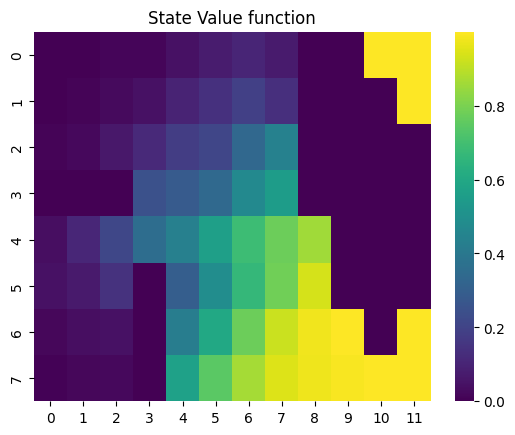

In [199]:
a = Dyna_Q_Agent(planning_steps=30)
a.fit(40)
a.report()